### Importation des librairies

In [2]:
%%capture capt
!pip install lifelines
!pip install tqdm
!pip install numpy==1.22
from tqdm import tqdm
import numpy as np
import pandas as pd
from lifelines.statistics import proportional_hazard_test
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
import statsmodels.stats.diagnostic as diag

### Base cluster unsupervised

In [6]:
profil_patient=pd.read_csv("../data/profil_patient_cluster.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient.head()

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,p_soins,Nb_jours_moyen
0,P0,2011-11-22,67,11,1,NaN,False,2596,9,0,...,0,0,0,0,0,0,0,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2...",2.555556
1,P6,2013-12-05,87,14,2,2015-03,True,456,8,0,...,0,0,0,0,1,0,0,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0...",6.375000
2,P8,2015-07-02,49,54,2,2015-08,True,41,3,1,...,0,0,0,0,0,1,0,0,"11M041,06C194",14.333333
3,P13,2011-05-19,57,974,1,NaN,False,2783,2,0,...,0,0,0,0,0,0,0,0,"05M04T,05K051",1.500000
4,P16,2010-03-18,69,76,1,NaN,False,3210,9,0,...,0,0,0,0,0,1,0,0,"08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M1...",3.111111


### Test Log-Rank

#### Entre clusters non supervisés

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

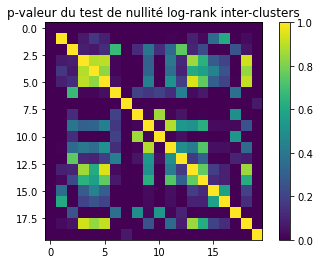

In [7]:
Matrice=np.zeros((20,20))
for i in range (1,20):
    for j in range (1,20):
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['cluster' + str(i)]==1], profil_patient['Nb_survie'][profil_patient['cluster' + str(j)]==1], event_observed_A=profil_patient['Mort'][profil_patient['cluster' + str(i)]==1], event_observed_B=profil_patient['Mort'][profil_patient['cluster' + str(j)]==1])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

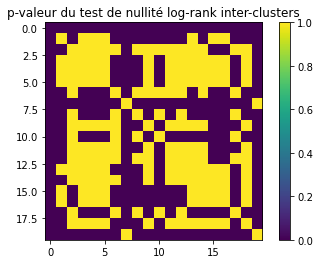

In [8]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")

#### Choc ou pas choc

p-valeur CHOC/PAS CHOC =
1.0571089917141666e-10


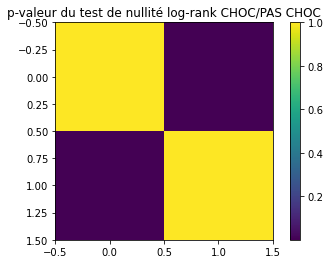

In [9]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i
        cluster_j=j
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_i], profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")
print("p-valeur CHOC/PAS CHOC =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==0], profil_patient['Nb_survie'][profil_patient['CHOC']==1], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==0], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==1]).p_value)

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank CHOC/PAS CHOC')

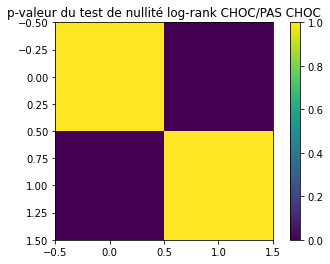

In [10]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

#### Homme ou femme

p-valeur HOMME/FEMME =
0.004273345157189771


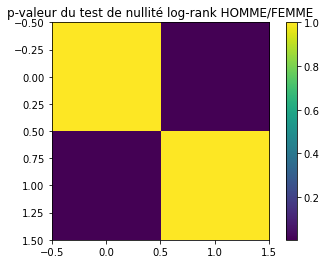

In [12]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i+1
        cluster_j=j+1
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_i], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank HOMME/FEMME")
print("p-valeur HOMME/FEMME =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==1], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==2], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==1], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==2]).p_value)

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank CHOC/PAS CHOC')

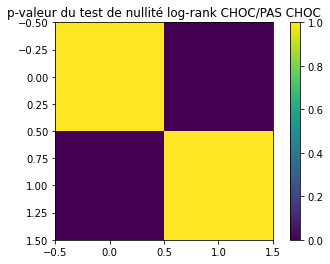

In [13]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

### Test COX en extrayant les patients pour chaque cluster

In [53]:
profil_patient=pd.read_csv("../data/profil_patient_cluster.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient=profil_patient.drop(['CODE_PATIENT', 'date_h0', 'BEN_RES_DPT','dte_deces', 'cat_age', 'cat_nb_hospit','cat_nb_jours_sej', 'p_soins', 'Nb_hospit', 'Nb_jours_sej'], axis=1)
profil_patient.head()

,y_nais,BEN_SEX_COD,Mort,Nb_survie,CHOC,cluster1,cluster2,cluster3,cluster4,cluster5,...,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,Nb_jours_moyen
0,67,1,False,2596,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.555556
1,87,2,True,456,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6.375000
2,49,2,True,41,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,14.333333
3,57,1,False,2783,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.500000
4,69,1,False,3210,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.111111


In [54]:
data_train, data_test = train_test_split(profil_patient, 
                                                    test_size=0.2, 
                                                    random_state=33)
                                                    #stratify = spooky_df['author_encoded'].values

In [58]:
data_train.head()

,y_nais,BEN_SEX_COD,Mort,Nb_survie,CHOC,cluster1,cluster2,cluster3,cluster4,cluster5,...,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,Nb_jours_moyen
907,54,1,True,226,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8.454545
8286,67,1,False,1509,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
1276,88,2,True,354,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,5.800000
5022,95,2,True,763,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.142857
401,53,1,True,236,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,9.818182


In [70]:
def extract_cluster_i(i):
    data_train_cluster=data_train[data_train['cluster' + str(i)]==1]
    for j in range(1,21):
        data_train_cluster=data_train_cluster.drop(['cluster' + str(j)], axis=1)
    return data_train_cluster

In [71]:
data_train_cluster= extract_cluster_i(1)
data_train_cluster

,y_nais,BEN_SEX_COD,Mort,Nb_survie,CHOC,Nb_jours_moyen
8286,67,1,False,1509,0,1.000000
3350,79,1,False,3274,0,1.285714
3982,93,2,True,12,0,7.000000
1627,89,1,True,1046,0,5.000000
4181,95,1,True,27,0,27.000000
...,...,...,...,...,...,...
5548,81,1,False,2292,0,5.000000
8753,83,1,True,681,0,6.818182
9419,83,2,True,2274,0,1.333333
1898,92,2,True,477,0,6.666667


In [76]:
for i in range (1,20):
    data_train_cluster= extract_cluster_i(i)
    cph = CoxPHFitter()
    cph.fit(data_train_cluster, duration_col='Nb_survie', event_col='Mort')
    cph.print_summary()
    #Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
    scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train_cluster, kind='scaled_schoenfeld')
    #print(scaled_schoenfeld_residuals)
    Variables=['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen']
    for variable in Variables:
        print('Pour la variable ' + str(variable) + ':')
        #Let's plot the residuals for AGE against time:
        #plt.plot(scaled_schoenfeld_residuals.index[:500], scaled_schoenfeld_residuals[variable][:500])
        #plt.show()
        #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
        result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)
        print(result)
        print('p-valeur du test de Ljung-Box: ' + str(result[1]))
        print('p-valeur du test de Box-Pierce test: ' + str(result[3]))
        print('Cela doit être plus grand que 0.05')
    cph.check_assumptions(data_train_cluster, p_value_threshold=0.05, show_plots=False)

<lifelines.CoxPHFitter: fitted with 377 total observations, 105 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 377
number of events observed = 272
   partial log-likelihood = -1427.27
         time fit was run = 2023-03-06 11:44:25 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.04       1.04       0.01             0.03             0.05                 1.03                 1.05
BEN_SEX_COD     -0.13       0.88       0.13            -0.38             0.12                 0.68                 1.13
CHOC             0.43       1.53       0.27            -0.10             0.95                 0.91                 2.58
Nb_jours_moyen   0.02       1.02       0.01             0.01             0.03                 1.01                 1.03

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  7.07 <0.005      39.20
BEN_SEX_COD        0.00 -1.00   0.32       1.65
CHOC               0.00  1.60   0.11       3.20
Nb_jours_moyen     0.00  2.69   0.01       7.15
---
Concordance = 0.63
Partial AIC = 2862.55
log-likelihood ratio test = 70.52 on 4 df
-log2(p) of ll-ratio test = 45.69

Pour la variable y_nais:
(array([40.43131929]), array([0.45120895]), array([36.84302553]), array([0.61316424]))
p-valeur du test de Ljung-Box: [0.45120895]
p-valeur du test de Box-Pierce test: [0.61316424]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([29.99789252]), array([0.87527752]), array([27.36161443]), array([0.93579908]))
p-valeur du test de Ljung-Box: [0.87527752]
p-valeur du test de Box-Pierce test: [0.93579908]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([43.37234059]), array([0.32958798]), array([39.12766512]), array([0.50937004]))
p-valeur du test de Ljung-Box: [0.32958798]
p-valeur du test de Box-Pierce test: [0.50937004]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([104.11999713]), array([1.2865805e-07]), array([96.98695102]), array([1.22992675e-06]))
p-valeur du test de Ljung-Box: [1.2865805e-07]
p-valeur du test de Box-Pierce test: [1.22992675e-06]
Cela doit être plus grand que 0.05
The ``p_va

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 377 total observations, 105 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              0.34   0.56      0.84
               rank            0.36   0.55      0.87
CHOC           km              1.69   0.19      2.37
               rank            1.84   0.17      2.52
Nb_jours_moyen km             10.43 <0.005      9.65
               rank           10.97 <0.005     10.07
y_nais         km              7.33   0.01      7.20
               rank            7.32   0.01      7.20



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0068.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0009.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

<lifelines.CoxPHFitter: fitted with 251 total observations, 83 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 251
number of events observed = 168
   partial log-likelihood = -809.93
         time fit was run = 2023-03-06 11:44:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.05       1.06       0.01             0.04             0.07                 1.04                 1.07
BEN_SEX_COD     -0.27       0.76       0.17            -0.61             0.07                 0.54                 1.07
CHOC             1.60       4.97       0.53             0.57             2.64                 1.77                13.94
Nb_jours_moyen   0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  5.90 <0.005      28.05
BEN_SEX_COD        0.00 -1.58   0.11       3.12
CHOC               0.00  3.04 <0.005       8.73
Nb_jours_moyen     0.00  1.66   0.10       3.36
---
Concordance = 0.64
Partial AIC = 1627.87
log-likelihood ratio test = 52.18 on 4 df
-log2(p) of ll-ratio test = 32.88

Pour la variable y_nais:
(array([32.07179764]), array([0.8097308]), array([27.87168929]), array([0.92608598]))
p-valeur du test de Ljung-Box: [0.8097308]
p-valeur du test de Box-Pierce test: [0.92608598]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([20.3828881]), array([0.99576684]), array([17.66673546]), array([0.9991523]))
p-valeur du test de Ljung-Box: [0.99576684]
p-valeur du test de Box-Pierce test: [0.9991523]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([42.57888088]), array([0.36070049]), array([37.06183758]), array([0.60326815]))
p-valeur du test de Ljung-Box: [0.36070049]
p-valeur du test de Box-Pierce test: [0.60326815]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([51.07560909]), array([0.11264854]), array([45.58678503]), array([0.25095166]))
p-valeur du test de Ljung-Box: [0.11264854]
p-valeur du test de Box-Pierce test: [0.25095166]
Cela doit être plus grand que 0.05
Proportional hazard assumption

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.CoxPHFitter: fitted with 341 total observations, 103 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 341
number of events observed = 238
   partial log-likelihood = -1236.91
         time fit was run = 2023-03-06 11:44:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.04       1.04       0.01             0.03             0.05                 1.03                 1.05
BEN_SEX_COD     -0.00       1.00       0.13            -0.27             0.26                 0.77                 1.29
CHOC             0.87       2.38       0.29             0.30             1.44                 1.35                 4.21
Nb_jours_moyen   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  6.24 <0.005      31.08
BEN_SEX_COD        0.00 -0.04   0.97       0.04
CHOC               0.00  2.99 <0.005       8.48
Nb_jours_moyen     0.00  0.69   0.49       1.03
---
Concordance = 0.62
Partial AIC = 2481.83
log-likelihood ratio test = 47.79 on 4 df
-log2(p) of ll-ratio test = 29.84

Pour la variable y_nais:
(array([46.59283411]), array([0.21953788]), array([43.12579891]), array([0.33910128]))
p-valeur du test de Ljung-Box: [0.21953788]
p-valeur du test de Box-Pierce test: [0.33910128]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([45.5081905]), array([0.25352211]), array([40.98428766]), array([0.4271522]))
p-valeur du test de Ljung-Box: [0.25352211]
p-valeur du test de Box-Pierce test: [0.4271522]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([36.84799943]), array([0.61293964]), array([33.53688218]), array([0.7548969]))
p-valeur du test de Ljung-Box: [0.61293964]
p-valeur du test de Box-Pierce test: [0.7548969]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([70.71942411]), array([0.00195084]), array([64.80655532]), array([0.00780854]))
p-valeur du test de Ljung-Box: [0.00195084]
p-valeur du test de Box-Pierce test: [0.00780854]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is s

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 341 total observations, 103 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              1.51 0.22      2.19
               rank            1.66 0.20      2.34
CHOC           km              6.24 0.01      6.32
               rank            6.32 0.01      6.39
Nb_jours_moyen km              1.15 0.28      1.81
               rank            1.20 0.27      1.87
y_nais         km              2.62 0.11      3.25
               rank            2.70 0.10      3.32



1. Variable 'CHOC' failed the non-proportional test: p-value is 0.0119.

   Advice: with so few unique values (only 2), you can include `strata=['CHOC', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 220 total observations, 49 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 220
number of events observed = 171
   partial log-likelihood = -797.08
         time fit was run = 2023-03-06 11:44:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
BEN_SEX_COD     -0.24       0.78       0.16            -0.55             0.07                 0.58                 1.07
CHOC            -0.51       0.60       0.39            -1.28             0.26                 0.28                 1.30
Nb_jours_moyen   0.05       1.05       0.02             0.02             0.08                 1.02                 1.09

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  1.67   0.10       3.39
BEN_SEX_COD        0.00 -1.54   0.12       3.01
CHOC               0.00 -1.30   0.19       2.36
Nb_jours_moyen     0.00  2.99 <0.005       8.48
---
Concordance = 0.56
Partial AIC = 1602.17
log-likelihood ratio test = 16.14 on 4 df
-log2(p) of ll-ratio test = 8.46

Pour la variable y_nais:


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([48.1876858]), array([0.17543]), array([42.79799686]), array([0.35196692]))
p-valeur du test de Ljung-Box: [0.17543]
p-valeur du test de Box-Pierce test: [0.35196692]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([26.88895294]), array([0.94398081]), array([22.77048567]), array([0.9869922]))
p-valeur du test de Ljung-Box: [0.94398081]
p-valeur du test de Box-Pierce test: [0.9869922]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([27.73642747]), array([0.92875262]), array([23.97169527]), array([0.97894766]))
p-valeur du test de Ljung-Box: [0.92875262]
p-valeur du test de Box-Pierce test: [0.97894766]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([42.52303549]), array([0.36294306]), array([36.31291799]), array([0.63698559]))
p-valeur du test de Ljung-Box: [0.36294306]
p-valeur du test de Box-Pierce test: [0.63698559]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is set at 0.05. Even under the nu

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 220 total observations, 49 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              1.88 0.17      2.55
               rank            2.13 0.14      2.79
CHOC           km              0.42 0.52      0.95
               rank            0.41 0.52      0.93
Nb_jours_moyen km              4.13 0.04      4.57
               rank            4.35 0.04      4.75
y_nais         km              3.77 0.05      4.26
               rank            3.97 0.05      4.43



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0464.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0371.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

<lifelines.CoxPHFitter: fitted with 221 total observations, 74 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 221
number of events observed = 147
   partial log-likelihood = -693.87
         time fit was run = 2023-03-06 11:44:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.04       1.04       0.01             0.02             0.06                 1.03                 1.06
BEN_SEX_COD     -0.20       0.82       0.18            -0.54             0.15                 0.58                 1.16
CHOC             0.45       1.57       0.52            -0.57             1.48                 0.56                 4.38
Nb_jours_moyen   0.03       1.03       0.01             0.01             0.05                 1.01                 1.05

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  4.95 <0.005      20.40
BEN_SEX_COD        0.00 -1.11   0.27       1.91
CHOC               0.00  0.86   0.39       1.36
Nb_jours_moyen     0.00  3.28 <0.005       9.93
---
Concordance = 0.64
Partial AIC = 1395.74
log-likelihood ratio test = 38.67 on 4 df
-log2(p) of ll-ratio test = 23.55

Pour la variable y_nais:
(array([50.4351185]), array([0.12477266]), array([45.66777011]), array([0.24832054]))
p-valeur du test de Ljung-Box: [0.12477266]
p-valeur du test de Box-Pierce test: [0.24832054]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([52.75414983]), array([0.08528547]), array([46.74040389]), array([0.21516371]))
p-valeur du test de Ljung-Box: [0.08528547]
p-valeur du test de Box-Pierce test: [0.21516371]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([36.39772859]), array([0.63319167]), array([31.47070276]), array([0.83028027]))
p-valeur du test de Ljung-Box: [0.63319167]
p-valeur du test de Box-Pierce test: [0.83028027]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([40.58272207]), array([0.44457881]), array([34.82133775]), array([0.70215117]))
p-valeur du test de Ljung-Box: [0.44457881]
p-valeur du test de Box-Pierce test: [0.70215117]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` 

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 221 total observations, 74 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              3.93 0.05      4.39
               rank            3.92 0.05      4.39
CHOC           km              5.01 0.03      5.31
               rank            5.01 0.03      5.31
Nb_jours_moyen km              3.20 0.07      3.77
               rank            3.62 0.06      4.13
y_nais         km              4.48 0.03      4.87
               rank            5.16 0.02      5.43



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0232.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'BEN_SEX_COD' failed the non-proportional test: p-value is 0.0475.

   Advice: with so few unique values (only 2), you can include `strata=['BEN_SEX_COD', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'CHOC' failed the non-proportional test: p-value is 0.0252.

   Advice: with so few unique values (only 2), you can 

<lifelines.CoxPHFitter: fitted with 421 total observations, 154 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 421
number of events observed = 267
   partial log-likelihood = -1422.30
         time fit was run = 2023-03-06 11:44:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.06       1.06       0.01             0.05             0.07                 1.05                 1.08
BEN_SEX_COD     -0.37       0.69       0.13            -0.63            -0.12                 0.54                 0.89
CHOC             0.86       2.37       0.29             0.30             1.43                 1.35                 4.17
Nb_jours_moyen   0.04       1.04       0.01             0.03             0.06                 1.03                 1.06

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  8.38 <0.005      54.09
BEN_SEX_COD        0.00 -2.85 <0.005       7.84
CHOC               0.00  3.01 <0.005       8.56
Nb_jours_moyen     0.00  5.35 <0.005      23.42
---
Concordance = 0.67
Partial AIC = 2852.59
log-likelihood ratio test = 112.43 on 4 df
-log2(p) of ll-ratio test = 75.26

Pour la variable y_nais:
(array([28.80067266]), array([0.90595989]), array([26.44491932]), array([0.95097318]))
p-valeur du test de Ljung-Box: [0.90595989]
p-valeur du test de Box-Pierce test: [0.95097318]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([43.03253075]), array([0.34273703]), array([38.74630774]), array([0.52664552]))
p-valeur du test de Ljung-Box: [0.34273703]
p-valeur du test de Box-Pierce test: [0.52664552]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([51.4754029]), array([0.10556706]), array([47.92186043]), array([0.1822997]))
p-valeur du test de Ljung-Box: [0.10556706]
p-valeur du test de Box-Pierce test: [0.1822997]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([103.80559937]), array([1.4237976e-07]), array([98.80634618]), array([6.97444263e-07]))
p-valeur du test de Ljung-Box: [1.4237976e-07]
p-valeur du test de Box-Pierce test: [6.97444263e-07]
Cela doit être plus grand que 0.05
The ``p_value

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 421 total observations, 154 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              0.26   0.61      0.71
               rank            0.38   0.54      0.90
CHOC           km              2.74   0.10      3.35
               rank            2.90   0.09      3.50
Nb_jours_moyen km              8.83 <0.005      8.40
               rank            9.54 <0.005      8.95
y_nais         km              0.64   0.42      1.23
               rank            0.57   0.45      1.15



1. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0020.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Nb_jours_moyen' using pd.cut, and then specify it in
`strata=['Nb_jours_moyen', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20h

<lifelines.CoxPHFitter: fitted with 435 total observations, 219 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 435
number of events observed = 216
   partial log-likelihood = -1142.66
         time fit was run = 2023-03-06 11:44:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.05       1.06       0.01             0.04             0.07                 1.04                 1.07
BEN_SEX_COD     -0.40       0.67       0.15            -0.68            -0.11                 0.50                 0.90
CHOC             1.31       3.70       0.32             0.68             1.94                 1.97                 6.93
Nb_jours_moyen   0.10       1.10       0.01             0.07             0.12                 1.07                 1.13

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  7.12 <0.005      39.72
BEN_SEX_COD        0.00 -2.70   0.01       7.15
CHOC               0.00  4.08 <0.005      14.44
Nb_jours_moyen     0.00  6.75 <0.005      36.03
---
Concordance = 0.72
Partial AIC = 2293.33
log-likelihood ratio test = 130.90 on 4 df
-log2(p) of ll-ratio test = 88.37

Pour la variable y_nais:
(array([36.05781306]), array([0.64835091]), array([33.12477925]), array([0.77095345]))
p-valeur du test de Ljung-Box: [0.64835091]
p-valeur du test de Box-Pierce test: [0.77095345]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([37.91283512]), array([0.56457869]), array([33.81886237]), array([0.74365092]))
p-valeur du test de Ljung-Box: [0.56457869]
p-valeur du test de Box-Pierce test: [0.74365092]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([26.36560473]), array([0.95215337]), array([23.67885636]), array([0.98119231]))
p-valeur du test de Ljung-Box: [0.95215337]
p-valeur du test de Box-Pierce test: [0.98119231]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([40.14586769]), array([0.46379024]), array([35.76327312]), array([0.66137568]))
p-valeur du test de Ljung-Box: [0.46379024]
p-valeur du test de Box-Pierce test: [0.66137568]
Cela doit être plus grand que 0.05
Proportional hazard assum

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.CoxPHFitter: fitted with 227 total observations, 92 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 227
number of events observed = 135
   partial log-likelihood = -627.65
         time fit was run = 2023-03-06 11:44:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.07       1.07       0.01             0.05             0.09                 1.05                 1.09
BEN_SEX_COD     -0.22       0.80       0.18            -0.58             0.14                 0.56                 1.15
CHOC             1.03       2.80       0.38             0.29             1.77                 1.34                 5.86
Nb_jours_moyen   0.05       1.05       0.01             0.02             0.07                 1.02                 1.08

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  6.67 <0.005      35.20
BEN_SEX_COD        0.00 -1.22   0.22       2.16
CHOC               0.00  2.74   0.01       7.33
Nb_jours_moyen     0.00  3.68 <0.005      12.06
---
Concordance = 0.71
Partial AIC = 1263.31
log-likelihood ratio test = 81.33 on 4 df
-log2(p) of ll-ratio test = 53.28

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Pour la variable y_nais:
(array([23.98338505]), array([0.97885396]), array([20.12076252]), array([0.9963141]))
p-valeur du test de Ljung-Box: [0.97885396]
p-valeur du test de Box-Pierce test: [0.9963141]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([71.03438778]), array([0.00180578]), array([59.64627439]), array([0.02350697]))
p-valeur du test de Ljung-Box: [0.00180578]
p-valeur du test de Box-Pierce test: [0.02350697]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([42.66279612]), array([0.35734338]), array([35.84463716]), array([0.65778898]))
p-valeur du test de Ljung-Box: [0.35734338]
p-valeur du test de Box-Pierce test: [0.65778898]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([56.56171606]), array([0.04302567]), array([49.2232756]), array([0.15046738]))
p-valeur du test de Ljung-Box: [0.04302567]
p-valeur du test de Box-Pierce test: [0.15046738]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 227 total observations, 92 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              0.10 0.75      0.42
               rank            0.09 0.76      0.40
CHOC           km              7.42 0.01      7.27
               rank            7.51 0.01      7.35
Nb_jours_moyen km              6.16 0.01      6.26
               rank            6.70 0.01      6.70
y_nais         km              1.06 0.30      1.72
               rank            1.09 0.30      1.75



1. Variable 'CHOC' failed the non-proportional test: p-value is 0.0061.

   Advice: with so few unique values (only 2), you can include `strata=['CHOC', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0096.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Nb_jours_moyen' using pd.cut, and then specify it in
`strata=['Nb_jours_moyen', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html


<lifelines.CoxPHFitter: fitted with 345 total observations, 114 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 345
number of events observed = 231
   partial log-likelihood = -1187.18
         time fit was run = 2023-03-06 11:44:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.06       1.06       0.01             0.04             0.07                 1.04                 1.07
BEN_SEX_COD     -0.23       0.79       0.14            -0.51             0.04                 0.60                 1.04
CHOC             1.80       6.03       0.31             1.19             2.40                 3.28                11.08
Nb_jours_moyen   0.01       1.01       0.00             0.00             0.02                 1.00                 1.02

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  7.53 <0.005      44.18
BEN_SEX_COD        0.00 -1.67   0.10       3.40
CHOC               0.00  5.80 <0.005      27.13
Nb_jours_moyen     0.00  2.70   0.01       7.19
---
Concordance = 0.66
Partial AIC = 2382.35
log-likelihood ratio test = 86.64 on 4 df
-log2(p) of ll-ratio test = 57.03

Pour la variable y_nais:
(array([29.26035779]), array([0.894814]), array([26.42208165]), array([0.95131511]))
p-valeur du test de Ljung-Box: [0.894814]
p-valeur du test de Box-Pierce test: [0.95131511]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([34.4812734]), array([0.71647553]), array([31.63705237]), array([0.82471499]))
p-valeur du test de Ljung-Box: [0.71647553]
p-valeur du test de Box-Pierce test: [0.82471499]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([45.06535734]), array([0.2683164]), array([41.34740215]), array([0.41161117]))
p-valeur du test de Ljung-Box: [0.2683164]
p-valeur du test de Box-Pierce test: [0.41161117]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([12.12208311]), array([0.99999401]), array([10.93951711]), array([0.99999866]))
p-valeur du test de Ljung-Box: [0.99999401]
p-valeur du test de Box-Pierce test: [0.99999866]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is set

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 345 total observations, 114 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              0.00 0.95      0.07
               rank            0.01 0.93      0.11
CHOC           km              0.03 0.86      0.21
               rank            0.04 0.84      0.25
Nb_jours_moyen km              5.24 0.02      5.50
               rank            5.25 0.02      5.51
y_nais         km              3.75 0.05      4.24
               rank            3.86 0.05      4.34



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0494.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0220.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

<lifelines.CoxPHFitter: fitted with 413 total observations, 169 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 413
number of events observed = 244
   partial log-likelihood = -1299.35
         time fit was run = 2023-03-06 11:44:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.05       1.05       0.01             0.04             0.06                 1.04                 1.07
BEN_SEX_COD     -0.39       0.68       0.14            -0.66            -0.12                 0.52                 0.88
CHOC             0.77       2.15       0.30             0.18             1.35                 1.20                 3.87
Nb_jours_moyen   0.05       1.05       0.01             0.03             0.07                 1.03                 1.07

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  8.53 <0.005      55.98
BEN_SEX_COD        0.00 -2.85 <0.005       7.85
CHOC               0.00  2.57   0.01       6.61
Nb_jours_moyen     0.00  5.20 <0.005      22.25
---
Concordance = 0.69
Partial AIC = 2606.69
log-likelihood ratio test = 119.26 on 4 df
-log2(p) of ll-ratio test = 80.11

Pour la variable y_nais:
(array([34.42538707]), array([0.71880662]), array([31.26641238]), array([0.83698449]))
p-valeur du test de Ljung-Box: [0.71880662]
p-valeur du test de Box-Pierce test: [0.83698449]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([43.99450381]), array([0.30622912]), array([40.57969385]), array([0.44471111]))
p-valeur du test de Ljung-Box: [0.30622912]
p-valeur du test de Box-Pierce test: [0.44471111]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([36.27631951]), array([0.6386205]), array([33.08414496]), array([0.77251121]))
p-valeur du test de Ljung-Box: [0.6386205]
p-valeur du test de Box-Pierce test: [0.77251121]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([87.18163048]), array([2.33813438e-05]), array([80.05403678]), array([0.00017373]))
p-valeur du test de Ljung-Box: [2.33813438e-05]
p-valeur du test de Box-Pierce test: [0.00017373]
Cela doit être plus grand que 0.05
The ``p_value_thres

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 413 total observations, 169 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              0.74 0.39      1.36
               rank            0.66 0.42      1.27
CHOC           km              1.89 0.17      2.57
               rank            1.89 0.17      2.56
Nb_jours_moyen km              3.62 0.06      4.13
               rank            3.71 0.05      4.21
y_nais         km              3.95 0.05      4.42
               rank            4.03 0.04      4.48



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0447.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0541.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

<lifelines.CoxPHFitter: fitted with 342 total observations, 112 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 342
number of events observed = 230
   partial log-likelihood = -1185.85
         time fit was run = 2023-03-06 11:44:28 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
BEN_SEX_COD     -0.07       0.94       0.14            -0.33             0.20                 0.72                 1.22
CHOC             0.73       2.07       0.34             0.05             1.40                 1.06                 4.05
Nb_jours_moyen   0.05       1.05       0.01             0.03             0.07                 1.03                 1.07

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  4.77 <0.005      19.05
BEN_SEX_COD        0.00 -0.48   0.63       0.66
CHOC               0.00  2.12   0.03       4.88
Nb_jours_moyen     0.00  5.67 <0.005      26.07
---
Concordance = 0.63
Partial AIC = 2379.70
log-likelihood ratio test = 56.34 on 4 df
-log2(p) of ll-ratio test = 35.77

Pour la variable y_nais:
(array([40.19343365]), array([0.46168677]), array([35.67453701]), array([0.66527696]))
p-valeur du test de Ljung-Box: [0.46168677]
p-valeur du test de Box-Pierce test: [0.66527696]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([51.70170194]), array([0.10171938]), array([46.64382681]), array([0.21801961]))
p-valeur du test de Ljung-Box: [0.10171938]
p-valeur du test de Box-Pierce test: [0.21801961]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([34.70739308]), array([0.70697689]), array([31.95253121]), array([0.81390385]))
p-valeur du test de Ljung-Box: [0.70697689]
p-valeur du test de Box-Pierce test: [0.81390385]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([59.37380164]), array([0.02483877]), array([54.21884409]), array([0.06610757]))
p-valeur du test de Ljung-Box: [0.02483877]
p-valeur du test de Box-Pierce test: [0.06610757]
Cela doit être plus grand que 0.05
The ``p_value_threshold``

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 342 total observations, 112 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              1.60   0.21      2.28
               rank            1.60   0.21      2.28
CHOC           km              0.13   0.72      0.47
               rank            0.12   0.73      0.45
Nb_jours_moyen km              6.56   0.01      6.59
               rank            7.07   0.01      7.00
y_nais         km             11.38 <0.005     10.40
               rank           11.84 <0.005     10.75



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0006.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0078.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

<lifelines.CoxPHFitter: fitted with 335 total observations, 103 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 335
number of events observed = 232
   partial log-likelihood = -1193.36
         time fit was run = 2023-03-06 11:44:28 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
BEN_SEX_COD     -0.38       0.69       0.14            -0.65            -0.10                 0.52                 0.90
CHOC             0.27       1.31       0.26            -0.24             0.77                 0.79                 2.16
Nb_jours_moyen   0.04       1.04       0.02             0.01             0.07                 1.01                 1.08

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  3.72 <0.005      12.30
BEN_SEX_COD        0.00 -2.69   0.01       7.11
CHOC               0.00  1.04   0.30       1.75
Nb_jours_moyen     0.00  2.86 <0.005       7.90
---
Concordance = 0.60
Partial AIC = 2394.72
log-likelihood ratio test = 34.93 on 4 df
-log2(p) of ll-ratio test = 20.99

Pour la variable y_nais:
(array([22.85859531]), array([0.98650102]), array([20.44885828]), array([0.995619]))
p-valeur du test de Ljung-Box: [0.98650102]
p-valeur du test de Box-Pierce test: [0.995619]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([51.51072817]), array([0.10495887]), array([46.84231273]), array([0.21217798]))
p-valeur du test de Ljung-Box: [0.10495887]
p-valeur du test de Box-Pierce test: [0.21217798]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([38.2793257]), array([0.54788304]), array([34.29488134]), array([0.72422369]))
p-valeur du test de Ljung-Box: [0.54788304]
p-valeur du test de Box-Pierce test: [0.72422369]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([46.43337878]), array([0.22433171]), array([41.55191936]), array([0.40295656]))
p-valeur du test de Ljung-Box: [0.22433171]
p-valeur du test de Box-Pierce test: [0.40295656]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is s

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 335 total observations, 103 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              1.59 0.21      2.27
               rank            1.80 0.18      2.48
CHOC           km              1.90 0.17      2.57
               rank            2.53 0.11      3.17
Nb_jours_moyen km              4.65 0.03      5.01
               rank            5.12 0.02      5.40
y_nais         km              1.07 0.30      1.73
               rank            1.03 0.31      1.69



1. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0236.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Nb_jours_moyen' using pd.cut, and then specify it in
`strata=['Nb_jours_moyen', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20h

<lifelines.CoxPHFitter: fitted with 260 total observations, 58 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 260
number of events observed = 202
   partial log-likelihood = -947.27
         time fit was run = 2023-03-06 11:44:28 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.04       1.04       0.01             0.02             0.05                 1.02                 1.06
BEN_SEX_COD      0.01       1.01       0.16            -0.30             0.32                 0.74                 1.37
CHOC             1.84       6.27       0.27             1.30             2.37                 3.66                10.74
Nb_jours_moyen  -0.03       0.97       0.02            -0.06             0.01                 0.94                 1.01

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  4.85 <0.005      19.63
BEN_SEX_COD        0.00  0.07   0.95       0.08
CHOC               0.00  6.68 <0.005      35.28
Nb_jours_moyen     0.00 -1.53   0.13       2.98
---
Concordance = 0.64
Partial AIC = 1902.54
log-likelihood ratio test = 57.18 on 4 df
-log2(p) of ll-ratio test = 36.36

Pour la variable y_nais:
(array([33.5883732]), array([0.7528586]), array([29.71247714]), array([0.88307911]))
p-valeur du test de Ljung-Box: [0.7528586]
p-valeur du test de Box-Pierce test: [0.88307911]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([36.14776004]), array([0.64435199]), array([31.88976338]), array([0.81608128]))
p-valeur du test de Ljung-Box: [0.64435199]
p-valeur du test de Box-Pierce test: [0.81608128]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([47.09181819]), array([0.20498858]), array([41.50727664]), array([0.40483941]))
p-valeur du test de Ljung-Box: [0.20498858]
p-valeur du test de Box-Pierce test: [0.40483941]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([68.06417353]), array([0.00369275]), array([62.66618426]), array([0.01249625]))
p-valeur du test de Ljung-Box: [0.00369275]
p-valeur du test de Box-Pierce test: [0.01249625]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 260 total observations, 58 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              3.91   0.05      4.38
               rank            3.63   0.06      4.14
CHOC           km              0.17   0.68      0.56
               rank            0.28   0.60      0.75
Nb_jours_moyen km             11.74 <0.005     10.68
               rank           14.35 <0.005     12.69
y_nais         km              2.94   0.09      3.53
               rank            2.71   0.10      3.33



1. Variable 'BEN_SEX_COD' failed the non-proportional test: p-value is 0.0481.

   Advice: with so few unique values (only 2), you can include `strata=['BEN_SEX_COD', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0002.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Nb_jours_moyen' using pd.cut, and then specify it in
`strata=['Nb_jours_moyen', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20as

<lifelines.CoxPHFitter: fitted with 296 total observations, 96 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 296
number of events observed = 200
   partial log-likelihood = -1001.54
         time fit was run = 2023-03-06 11:44:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
BEN_SEX_COD     -0.33       0.72       0.15            -0.62            -0.05                 0.54                 0.95
CHOC             0.51       1.66       1.02            -1.49             2.51                 0.23                12.25
Nb_jours_moyen   0.05       1.05       0.01             0.03             0.07                 1.03                 1.08

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  5.54 <0.005      25.00
BEN_SEX_COD        0.00 -2.28   0.02       5.45
CHOC               0.00  0.50   0.62       0.69
Nb_jours_moyen     0.00  4.34 <0.005      16.08
---
Concordance = 0.63
Partial AIC = 2011.08
log-likelihood ratio test = 65.12 on 4 df
-log2(p) of ll-ratio test = 41.90

Pour la variable y_nais:
(array([27.44268947]), array([0.93431724]), array([24.20158752]), array([0.97704536]))
p-valeur du test de Ljung-Box: [0.93431724]
p-valeur du test de Box-Pierce test: [0.97704536]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([31.4029946]), array([0.83251828]), array([27.25402898]), array([0.93772971]))
p-valeur du test de Ljung-Box: [0.83251828]
p-valeur du test de Box-Pierce test: [0.93772971]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([1.54292058]), array([1.]), array([1.35887631]), array([1.]))
p-valeur du test de Ljung-Box: [1.]
p-valeur du test de Box-Pierce test: [1.]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([59.78762268]), array([0.02284156]), array([54.10158815]), array([0.06749633]))
p-valeur du test de Ljung-Box: [0.02284156]
p-valeur du test de Box-Pierce test: [0.06749633]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is set at 0.05. Even under the nul

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 296 total observations, 96 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              0.03   0.86      0.21
               rank            0.03   0.87      0.20
CHOC           km              2.17   0.14      2.83
               rank            2.33   0.13      2.98
Nb_jours_moyen km             10.69 <0.005      9.86
               rank           11.01 <0.005     10.11
y_nais         km              2.19   0.14      2.85
               rank            2.17   0.14      2.83



1. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0009.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Nb_jours_moyen' using pd.cut, and then specify it in
`strata=['Nb_jours_moyen', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20h

<lifelines.CoxPHFitter: fitted with 500 total observations, 114 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 386
   partial log-likelihood = -2114.57
         time fit was run = 2023-03-06 11:44:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
BEN_SEX_COD     -0.34       0.71       0.10            -0.55            -0.14                 0.58                 0.87
CHOC             0.30       1.35       0.29            -0.26             0.86                 0.77                 2.36
Nb_jours_moyen   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  5.23 <0.005      22.53
BEN_SEX_COD        0.00 -3.29 <0.005       9.94
CHOC               0.00  1.04   0.30       1.75
Nb_jours_moyen     0.00  4.58 <0.005      17.72
---
Concordance = 0.59
Partial AIC = 4237.14
log-likelihood ratio test = 51.84 on 4 df
-log2(p) of ll-ratio test = 32.64

Pour la variable y_nais:
(array([42.40748893]), array([0.36760416]), array([39.68790086]), array([0.4841715]))
p-valeur du test de Ljung-Box: [0.36760416]
p-valeur du test de Box-Pierce test: [0.4841715]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([44.84721351]), array([0.27579689]), array([42.43020125]), array([0.36668573]))
p-valeur du test de Ljung-Box: [0.27579689]
p-valeur du test de Box-Pierce test: [0.36668573]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([28.57373801]), array([0.9111711]), array([27.13452489]), array([0.93982673]))
p-valeur du test de Ljung-Box: [0.9111711]
p-valeur du test de Box-Pierce test: [0.93982673]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([78.39566412]), array([0.00027193]), array([74.16301744]), array([0.0008239]))
p-valeur du test de Ljung-Box: [0.00027193]
p-valeur du test de Box-Pierce test: [0.0008239]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is se

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 500 total observations, 114 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              1.44   0.23      2.12
               rank            1.65   0.20      2.33
CHOC           km              1.27   0.26      1.94
               rank            1.17   0.28      1.84
Nb_jours_moyen km              8.29 <0.005      7.97
               rank            8.77 <0.005      8.35
y_nais         km              5.55   0.02      5.76
               rank            5.88   0.02      6.03



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0153.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0031.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functi

<lifelines.CoxPHFitter: fitted with 309 total observations, 76 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 309
number of events observed = 233
   partial log-likelihood = -1161.54
         time fit was run = 2023-03-06 11:44:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
BEN_SEX_COD     -0.30       0.74       0.14            -0.57            -0.03                 0.57                 0.97
CHOC             0.63       1.88       0.27             0.10             1.16                 1.11                 3.19
Nb_jours_moyen   0.04       1.04       0.01             0.02             0.06                 1.02                 1.06

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  5.43 <0.005      24.08
BEN_SEX_COD        0.00 -2.19   0.03       5.12
CHOC               0.00  2.35   0.02       5.72
Nb_jours_moyen     0.00  3.54 <0.005      11.30
---
Concordance = 0.61
Partial AIC = 2331.09
log-likelihood ratio test = 54.08 on 4 df
-log2(p) of ll-ratio test = 34.20

Pour la variable y_nais:
(array([52.48338373]), array([0.08929016]), array([47.60284606]), array([0.19079708]))
p-valeur du test de Ljung-Box: [0.08929016]
p-valeur du test de Box-Pierce test: [0.19079708]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([31.35899307]), array([0.8339642]), array([28.29653995]), array([0.91727689]))
p-valeur du test de Ljung-Box: [0.8339642]
p-valeur du test de Box-Pierce test: [0.91727689]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([43.41582387]), array([0.32792494]), array([39.80898494]), array([0.47876138]))
p-valeur du test de Ljung-Box: [0.32792494]
p-valeur du test de Box-Pierce test: [0.47876138]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([40.18051689]), array([0.46225771]), array([36.9154738]), array([0.6098911]))
p-valeur du test de Ljung-Box: [0.46225771]
p-valeur du test de Box-Pierce test: [0.6098911]
Cela doit être plus grand que 0.05
The ``p_value_threshold`` is s

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 309 total observations, 76 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              2.08   0.15      2.74
               rank            2.10   0.15      2.76
CHOC           km              1.91   0.17      2.58
               rank            2.13   0.14      2.79
Nb_jours_moyen km              2.14   0.14      2.80
               rank            2.47   0.12      3.11
y_nais         km             10.30 <0.005      9.56
               rank           10.49 <0.005      9.71



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0012.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduc

<lifelines.CoxPHFitter: fitted with 600 total observations, 234 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 600
number of events observed = 366
   partial log-likelihood = -2111.67
         time fit was run = 2023-03-06 11:44:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.04       1.04       0.01             0.03             0.05                 1.03                 1.06
BEN_SEX_COD     -0.25       0.78       0.11            -0.46            -0.04                 0.63                 0.96
CHOC             0.94       2.56       0.27             0.40             1.47                 1.50                 4.37
Nb_jours_moyen   0.05       1.05       0.01             0.03             0.07                 1.03                 1.07

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  6.21 <0.005      30.86
BEN_SEX_COD        0.00 -2.31   0.02       5.57
CHOC               0.00  3.44 <0.005      10.76
Nb_jours_moyen     0.00  4.37 <0.005      16.26
---
Concordance = 0.61
Partial AIC = 4231.34
log-likelihood ratio test = 76.78 on 4 df
-log2(p) of ll-ratio test = 50.08

Pour la variable y_nais:
(array([47.70135078]), array([0.1881437]), array([45.06632142]), array([0.26828362]))
p-valeur du test de Ljung-Box: [0.1881437]
p-valeur du test de Box-Pierce test: [0.26828362]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([63.72973773]), array([0.00991473]), array([59.64666143]), array([0.02350513]))
p-valeur du test de Ljung-Box: [0.00991473]
p-valeur du test de Box-Pierce test: [0.02350513]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([97.45322145]), array([1.06412433e-06]), array([94.06458022]), array([3.0195651e-06]))
p-valeur du test de Ljung-Box: [1.06412433e-06]
p-valeur du test de Box-Pierce test: [3.0195651e-06]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([264.57393115]), array([6.90140766e-35]), array([250.63913096]), array([2.64460161e-32]))
p-valeur du test de Ljung-Box: [6.90140766e-35]
p-valeur du test de Box-Pierce test: [2.64460161e-32]
Cela doit être plus grand que 

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 600 total observations, 234 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              0.84   0.36      1.48
               rank            1.14   0.28      1.81
CHOC           km             15.95 <0.005     13.91
               rank           16.33 <0.005     14.19
Nb_jours_moyen km             27.85 <0.005     22.86
               rank           29.96 <0.005     24.43
y_nais         km              9.94 <0.005      9.27
               rank            9.49 <0.005      8.92



1. Variable 'y_nais' failed the non-proportional test: p-value is 0.0016.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'CHOC' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['CHOC', ...]` in the call in
`.fit`. See documentation in link [E] below.

3. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Nb_jours_

<lifelines.CoxPHFitter: fitted with 749 total observations, 236 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 513
   partial log-likelihood = -3013.85
         time fit was run = 2023-03-06 11:44:30 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.05       1.05       0.00             0.04             0.05                 1.04                 1.06
BEN_SEX_COD     -0.06       0.94       0.09            -0.24             0.12                 0.78                 1.13
CHOC             1.08       2.94       0.21             0.66             1.50                 1.94                 4.47
Nb_jours_moyen   0.04       1.04       0.01             0.02             0.05                 1.02                 1.05

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00 10.63 <0.005      85.22
BEN_SEX_COD        0.00 -0.67   0.50       0.99
CHOC               0.00  5.05 <0.005      21.12
Nb_jours_moyen     0.00  5.35 <0.005      23.41
---
Concordance = 0.65
Partial AIC = 6035.70
log-likelihood ratio test = 193.45 on 4 df
-log2(p) of ll-ratio test = 132.94

Pour la variable y_nais:
(array([66.49022326]), array([0.00532828]), array([63.40885917]), array([0.01063669]))
p-valeur du test de Ljung-Box: [0.00532828]
p-valeur du test de Box-Pierce test: [0.01063669]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([32.08104177]), array([0.80940541]), array([31.04067749]), array([0.84422273]))
p-valeur du test de Ljung-Box: [0.80940541]
p-valeur du test de Box-Pierce test: [0.84422273]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([91.3649675]), array([6.81973911e-06]), array([87.19280272]), array([2.33057326e-05]))
p-valeur du test de Ljung-Box: [6.81973911e-06]
p-valeur du test de Box-Pierce test: [2.33057326e-05]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([283.0917843]), array([2.35186856e-38]), array([272.68327753]), array([2.11356041e-36]))
p-valeur du test de Ljung-Box: [2.35186856e-38]
p-valeur du test de Box-Pierce test: [2.11356041e-36]
Cela doit être plus grand qu

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 749 total observations, 236 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              2.24   0.13      2.90
               rank            2.37   0.12      3.02
CHOC           km              7.48   0.01      7.33
               rank            7.63   0.01      7.45
Nb_jours_moyen km             28.34 <0.005     23.23
               rank           29.91 <0.005     24.40
y_nais         km             20.73 <0.005     17.53
               rank           20.66 <0.005     17.48



1. Variable 'y_nais' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'CHOC' failed the non-proportional test: p-value is 0.0057.

   Advice: with so few unique values (only 2), you can include `strata=['CHOC', ...]` in the call in
`.fit`. See documentation in link [E] below.

3. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Nb_jours_

<lifelines.CoxPHFitter: fitted with 1180 total observations, 485 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 1180
number of events observed = 695
   partial log-likelihood = -4430.01
         time fit was run = 2023-03-06 11:44:30 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.03       1.03       0.00             0.02             0.03                 1.02                 1.03
BEN_SEX_COD     -0.21       0.81       0.08            -0.36            -0.05                 0.70                 0.95
CHOC             0.31       1.36       0.14             0.03             0.58                 1.03                 1.79
Nb_jours_moyen   0.07       1.08       0.01             0.05             0.10                 1.05                 1.10

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00  7.24 <0.005      41.01
BEN_SEX_COD        0.00 -2.65   0.01       6.95
CHOC               0.00  2.19   0.03       5.12
Nb_jours_moyen     0.00  6.59 <0.005      34.44
---
Concordance = 0.61
Partial AIC = 8868.02
log-likelihood ratio test = 120.17 on 4 df
-log2(p) of ll-ratio test = 80.75

Pour la variable y_nais:
(array([48.41272579]), array([0.16976314]), array([46.46558383]), array([0.22335787]))
p-valeur du test de Ljung-Box: [0.16976314]
p-valeur du test de Box-Pierce test: [0.22335787]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:
(array([53.43766705]), array([0.07582966]), array([51.70104216]), array([0.10173043]))
p-valeur du test de Ljung-Box: [0.07582966]
p-valeur du test de Box-Pierce test: [0.10173043]
Cela doit être plus grand que 0.05
Pour la variable CHOC:
(array([46.41959879]), array([0.22474928]), array([44.80025991]), array([0.27742347]))
p-valeur du test de Ljung-Box: [0.22474928]
p-valeur du test de Box-Pierce test: [0.27742347]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:
(array([48.85405029]), array([0.15904234]), array([47.42065816]), array([0.19577445]))
p-valeur du test de Ljung-Box: [0.15904234]
p-valeur du test de Box-Pierce test: [0.19577445]
Cela doit être plus grand que 0.05
The ``p_value_threshold``

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1180 total observations, 485 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
BEN_SEX_COD    km              0.23 0.63      0.66
               rank            0.33 0.57      0.82
CHOC           km              0.52 0.47      1.09
               rank            0.72 0.40      1.33
Nb_jours_moyen km              4.96 0.03      5.27
               rank            5.82 0.02      5.98
y_nais         km              0.04 0.83      0.26
               rank            0.21 0.65      0.63



1. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is 0.0159.

   Advice 1: the functional form of the variable 'Nb_jours_moyen' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Nb_jours_moyen' using pd.cut, and then specify it in
`strata=['Nb_jours_moyen', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20h